# This notebook aims at presenting the cluster pipeline for 
# stacked $\Delta\Sigma$ profiles and counts in richness/redshift bins

In [1]:
import os
from pprint import pprint
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import ceci
import h5py
import yaml

Make sure to change your path in the next cell that leads to your TXPipe directory. See examples for IN2P3 and NERSC below.

In [2]:
#user specific paths -- IN2P3 example
my_txpipe_dir = "/pbs/home/m/mricci/throng_mricci/desc/TXPipe"

#user specific paths -- NERSC example
#my_txpipe_dir = "/pscratch/sd/a/avestruz/TXPipe"

os.chdir(my_txpipe_dir)

import txpipe

# let's use the pipeline approach

Here we will use the 20deg2, but we can also use the 1deg2 files (just need to change 20deg2 to 1deg2 in the name of the files)

### Launching a pipeline

Let's have a look at the submission script for this pipeline:
- to work at CCin2p3 we can use: `examples/cosmodc2/Cluster_pipelines/cosmodc2/20deg2-in2p3.sub`:
- to work at NERSC we can use: `examples/cosmodc2/Cluster_pipelines/cosmodc2/20deg2-nersc.sub`:

## This comand will run the pipeline
This will launch a job of up to one hour (it should finish in 30 min) on a single CC-IN2P3 node to run a pipeline. After the first run, the output files are created and following runs take much less time.




> ### In a terminal, **navigate to your TXPipe directory on IN2P3 and run**:
>```
sbatch examples/Cluster_pipelines/cosmodc2/20deg2-in2p3.sub
```


> ### If you are **on NERSC, you will instead run**:
>```
sbatch examples/Cluster_pipelines/cosmodc2/20deg2-nersc.sub
```

## Let's look at the file content 

### Let's look at the submission_script :

=> If we use the CCin2p3 example:

In [3]:
! cat examples/cosmodc2/Cluster_pipelines/20deg2-in2p3.sub

#!/usr/bin/bash
#SBATCH --time=01:00:00
#SBATCH --partition=hpc
#SBATCH --ntasks=30
#SBATCH --cpus-per-task=1
#SBATCH --mem=128000

source /pbs/throng/lsst/users/jzuntz/txpipe-environments/setup-txpipe
ceci examples/cosmodc2/Cluster_pipelines/pipeline-20deg2-CL-in2p3.yml


=> If we use the NERSC example:

In [4]:
! cat examples/cosmodc2/Cluster_pipelines/20deg2-nersc.sub

#!/bin/bash
#SBATCH -A m1727
#SBATCH -C cpu
#SBATCH --qos=debug
#SBATCH --time=00:30:00
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=32

source $CFS/lsst/groups/WL/users/zuntz/setup-txpipe
tx ceci examples/cosmodc2/Cluster_pipelines/pipeline-20deg2-CL-nersc.yml


### Let's look at the pipeline_file :

In [5]:
! cat examples/cosmodc2/Cluster_pipelines/pipeline-20deg2-CL-in2p3.yml

#this step depends on where you run
#for CCin2p3
site:
    name: cc-parallel
    mpi_command: "mpirun -n"

#for NERSC
#site:
#    name: cori-batch
#    image: ghcr.io/lsstdesc/txpipe-dev


#all the following steps should not depend on where you run 
launcher:
    name: mini
    interval: 3.0
modules: >
    txpipe
    rail.estimation.algos.bpz_lite

python_paths: []

stages:
    - name: TXSourceSelectorMetadetect
      nprocess: 30
    - name: Inform_BPZ_lite
      nprocess: 1
    - name: BPZ_lite
      nprocess: 30
    - name: CLClusterBinningRedshiftRichness
      nprocess: 1
    - name: CLClusterShearCatalogs
      nprocess: 1 #>1 does not work with mpi
    - name: CLClusterEnsembleProfiles
      nprocess: 1
#    - name: CLClusterDataVector
#      nprocess: 1



output_dir: ./data/cosmodc2/outputs-20deg2-CL
config: ./examples/cosmodc2/Cluster_pipelines/config-20deg2-CL.yml

inputs:
    # See README for paths to download these files
    shear_catalog:  ./data/cosmodc2/20deg2/shear_cat

### Here we have 6 uncommented stages, and 5 uncommented inputs files. 
### This translate in the pipeline charts as 6 red ellipses, and 5 yellow boxes.

In [6]:
# Read the appropriate pipeline configuration, and ask for a flow-chart.
pipeline_file = "examples/cosmodc2/Cluster_pipelines/pipeline-20deg2-CL-in2p3.yml"
#pipeline_file = "examples/cosmodc2/pipeline-1deg2-CL-nersc.yml"
flowchart_file = "CL_pipeline.png"


pipeline_config = ceci.Pipeline.build_config(
    pipeline_file,
    flow_chart=flowchart_file,
    dry_run=True
)

# Run the flow-chart pipeline
ceci.run_pipeline(pipeline_config)

0

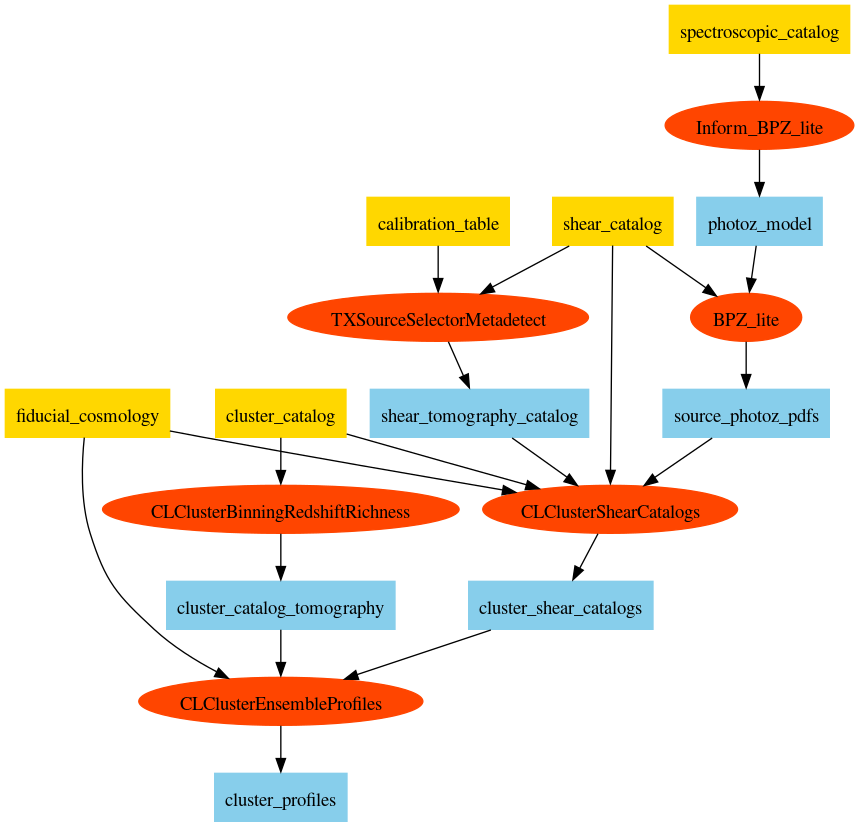

In [ ]:
Image(flowchart_file)

In [ ]:
## Open the corresponding pipeline file to load correct input/output file names

In [9]:
with open(pipeline_file, 'r') as file:
    pipeline_content = yaml.safe_load(file)


In [20]:
with open(yaml.safe_load(pipeline_content['config']), 'r') as file:
    config_content = yaml.safe_load(file)

In [21]:
config_bin_info = config_content['CLClusterBinningRedshiftRichness']

In [10]:
#open output binning output
filename_out =pipeline_content['output_dir']+"/cluster_catalog_tomography.hdf5"
print (filename_out)
f_out = h5py.File(filename_out, "r")
dat_out = f_out['provenance']
dset_out = f_out['cluster_bin']


./data/cosmodc2/outputs-20deg2-CL/cluster_catalog_tomography.hdf5


In [11]:
[print (i, dict(dset_out[i].attrs), dset_out[i]['redshift'][:].size) for i in dset_out.keys()];

bin_zbin_0_richbin_0 {'rich_max': 10.0, 'rich_min': 5.0, 'z_max': 0.4, 'z_min': 0.2} 147
bin_zbin_0_richbin_1 {'rich_max': 20.0, 'rich_min': 10.0, 'z_max': 0.4, 'z_min': 0.2} 37
bin_zbin_0_richbin_2 {'rich_max': 25.0, 'rich_min': 20.0, 'z_max': 0.4, 'z_min': 0.2} 5
bin_zbin_0_richbin_3 {'rich_max': 50.0, 'rich_min': 25.0, 'z_max': 0.4, 'z_min': 0.2} 7
bin_zbin_1_richbin_0 {'rich_max': 10.0, 'rich_min': 5.0, 'z_max': 0.6, 'z_min': 0.4} 376
bin_zbin_1_richbin_1 {'rich_max': 20.0, 'rich_min': 10.0, 'z_max': 0.6, 'z_min': 0.4} 120
bin_zbin_1_richbin_2 {'rich_max': 25.0, 'rich_min': 20.0, 'z_max': 0.6, 'z_min': 0.4} 14
bin_zbin_1_richbin_3 {'rich_max': 50.0, 'rich_min': 25.0, 'z_max': 0.6, 'z_min': 0.4} 25
bin_zbin_2_richbin_0 {'rich_max': 10.0, 'rich_min': 5.0, 'z_max': 0.8, 'z_min': 0.6} 293
bin_zbin_2_richbin_1 {'rich_max': 20.0, 'rich_min': 10.0, 'z_max': 0.8, 'z_min': 0.6} 83
bin_zbin_2_richbin_2 {'rich_max': 25.0, 'rich_min': 20.0, 'z_max': 0.8, 'z_min': 0.6} 8
bin_zbin_2_richbin_3 {'

In [86]:
n_counts = np.empty((len(config_bin_info['richedge'])-1, len(config_bin_info['zedge'])-1))

for i in range(len(config_bin_info['zedge'])-1):
    for j in range(len(config_bin_info['richedge'])-1):
        n_counts[j,i] = dset_out['bin_zbin_'+str(i)+'_richbin_'+str(j)]['redshift'][:].size


In [87]:
n_counts

array([[147., 376., 293.],
       [ 37., 120.,  83.],
       [  5.,  14.,   8.],
       [  7.,  25.,  15.]])

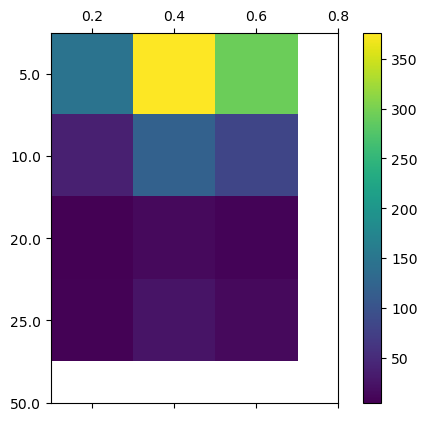

In [88]:
fig, ax = plt.subplots()

cax = ax.matshow(n_counts, cmap='viridis')
fig.colorbar(cax)

ax.set_xticks(np.arange(4))
ax.set_yticks(np.arange(5))

ax.set_xticklabels(config_bin_info['zedge'])
ax.set_yticklabels(config_bin_info['richedge']);



#ax.set_yticks(xaxis)

In [93]:
import pickle as pkl

In [108]:
data = pkl.load(open(pipeline_content['output_dir']+"/cluster_profiles.pkl","rb"))

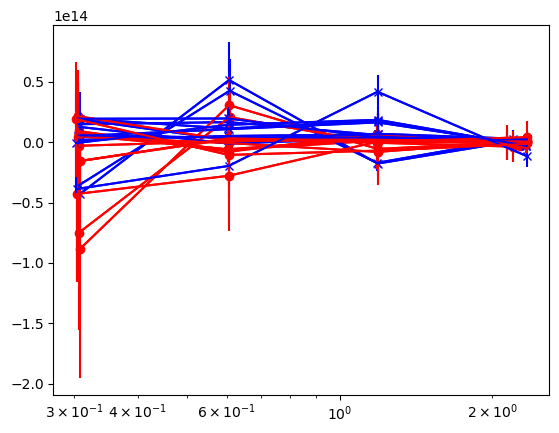

In [113]:
fig, ax = plt.subplots()

for k in data.keys():
    cl_stacked_data = data[k]
    
    ax.semilogx(cl_stacked_data.stacked_data['radius'],cl_stacked_data.stacked_data['tangential_comp'],'bx-',label="tan")
    ax.semilogx(cl_stacked_data.stacked_data['radius'],cl_stacked_data.stacked_data['cross_comp'],'ro-',label="cross")

    ax.errorbar(cl_stacked_data.stacked_data['radius'], cl_stacked_data.stacked_data['tangential_comp'], yerr=cl_stacked_data.cov['tan_sc'].diagonal() ** 0.5 , color='blue')
    ax.errorbar(cl_stacked_data.stacked_data['radius'], cl_stacked_data.stacked_data['cross_comp'], yerr=cl_stacked_data.cov['cross_sc'].diagonal() ** 0.5 , color='red')
